In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, rc
from astropy import cosmology, units, constants

from ska_simulator.power_spectrum import power_spectrum
from ska_simulator.simulations import cosmological_signal


%load_ext autoreload
%autoreload 2

In [2]:
rc("font", **{"family": "serif", "serif": ["times new roman"], "size": 15})
rc("text", usetex=True)
rc("axes", linewidth=1.5)

In [3]:
datafolder = '../test_dataset/'

# k-range
kperp_bins = np.loadtxt(f'{datafolder}bins_kper.txt')
kpara_bins = np.loadtxt(f'{datafolder}bins_kpar.txt')
k_mag = np.sqrt(kpara_bins[:, None]**2 + kperp_bins[None, :]**2)

kmin = np.min(k_mag) / units.Mpc
kmax = np.max(k_mag) / units.Mpc
krange = np.linspace(kmin, kmax, 10).value


In [7]:
cos = cosmology.FlatLambdaCDM(Om0=0.30964, H0=100.)

In [11]:
# 21cm rest-frame frequency
nu0 = 1420e6 * units.Hz

## Parameters

In [12]:
# Simulation angular specs
ang_res = 16.*units.arcsec # angular resolution
#number of pixels in row and col (ang res)
npix = 2048
#length and width of the box in Mpc
fov = ang_res.to(units.rad) * npix #rad

In [13]:
# Simulation spectral specs
nfreqs = 151
fmin = 166. * units.MHz
fmax = 181. * units.MHz
spw_window = np.linspace(fmin.value, fmax.value, nfreqs, endpoint=True) * units.MHz
avg_z = np.mean(nu0/spw_window.to(units.Hz) - 1.)
df = np.median(np.diff(spw_window)).to(units.Hz)

z_array = nu0/spw_window - 1.
avg_nu = np.mean(spw_window)
avg_z = np.mean(z_array)
avg_lamb = constants.c.si / avg_nu.si

print(f'{spw_window.size} frequency channels, '
      f'mean frequency {avg_nu.to(units.MHz):.1f}, '
      f'mean redshift {avg_z:.1f}.')

151 frequency channels, mean frequency 173.5 MHz, mean redshift 7.2.


To obtain the comoving length $L$ in the $z$ direction, we use
\begin{equation}
L= \frac{c \sqrt{1+z}}{H_0 \nu_0 \sqrt{\Omega_{\mathrm{m}}}}  \Delta \nu
\end{equation}
for $\Delta \nu$ the bandwidth in Hz.

In [14]:
# Simulation comoving specs
L = fov.value * cos.comoving_distance(avg_z.value)
Lz = (constants.c * (1.0 + avg_z) ** 2
      / cos.H(avg_z.value).si
      / nu0 * df * nfreqs).to(units.Mpc)
print(f'Simulation is {L:.1f} long on the side, '
      f'{Lz:.1f} along the line-of-sight.')

Simulation is 956.0 Mpc long on the side, 163.6 Mpc along the line-of-sight.


In [15]:
dx = L/npix
dz = Lz/nfreqs
print(dx**2 * dz)

0.2361083485437187 Mpc3


In [16]:
kmin = 2.*np.pi * min(1./L, 1./Lz) * 2.
kmax = 2.*np.pi * max(npix/L, nfreqs/Lz) / 2.
print(kmin, kmax)
krange = np.linspace(kmin, kmax, 100).value

0.013144744184177824 1 / Mpc 6.730109022299046 1 / Mpc


In [37]:
# Beam FWHM
bmaj = 0.04413
bmin = 0.03291
beam_fwhm = np.array([bmaj, bmin]) * units.deg
beam_sigma = beam_fwhm / (8 * np.log(2))**0.5
omega_B = 2 * np.pi * beam_sigma[0] * beam_sigma[1]
print(f'Beam area = {omega_B:.2e}')


Beam area = 1.65e-03 deg2


## Generate cosmological random field

### Choose power spectrum

In [19]:
def flat_ps(k, amp=10e-3):
    """
    Generate a flat power spectrum of amplitude amp.

    Parameters
    ----------
        k: float or array of flats
            Fourier mode in Mpc-1.
        amp: float
            Desired amplitude for the PS, in K2.

    """
    k = np.atleast_1d(k)
    return amp * np.ones(k.shape)


Text(0.5, 0, '$k$ [Mpc$^{-1}$]')

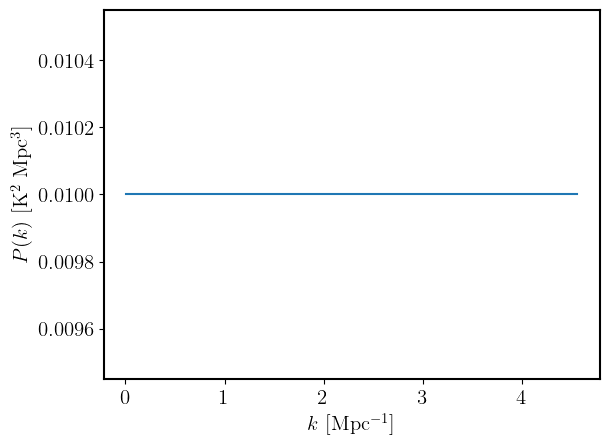

In [20]:
amp = 10e-3 # mK2

plt.figure()
plt.plot(krange, flat_ps(krange, amp))
plt.ylabel(r"$P(k)$ [K$^2$ Mpc$^3$]")
plt.xlabel(r"$k$ [Mpc$^{-1}$]")


### Generate lightcone

In [35]:
#make a lil universe
cosmo_signal = cosmological_signal(
    flat_ps,
    spw_window,
    npix,
    ang_res,
    cos=cosmology.Planck18,
    verbose=False,
)

In [36]:
cosmo_box = cosmo_signal.make_universe() * units.K

In [38]:
cosmo_box_Jy = cosmo_box.to(
    units.Jy/units.beam,
    equivalencies=units.brightness_temperature(
        spw_window,
        beam_area=omega_B
    )
)
print('Standard deviation of the cosmological simulation: '
      f'{np.std(cosmo_box[..., nfreqs//2]).to(units.mK):.2e} '
      f'or {np.std(cosmo_box_Jy[..., nfreqs//2]):.2e}.')


Standard deviation of the cosmological simulation: 1.15e+02 mK or 5.32e-05 Jy / beam.


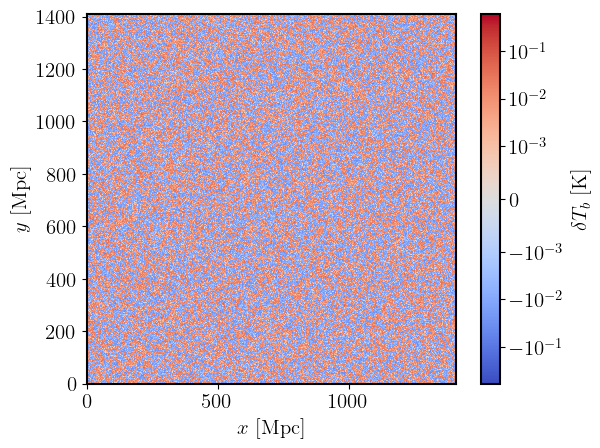

In [40]:
#Let's see a random freq slice 
plt.figure()
plt.imshow(cosmo_box[:, :, 43].value,
           origin='lower',
           extent=(0, L.value, 0, L.value),
           cmap='coolwarm',
           norm=colors.SymLogNorm(1e-3))
plt.xlabel(r'$x$ [Mpc]')
plt.ylabel(r'$y$ [Mpc]')
plt.colorbar(label=r'$\delta T_b$ [K]')

### Compute power spectrum numerically from the simulation

In [41]:
# power spectrum of cosmo signal only
pspec_cosmo = power_spectrum(
    data=cosmo_box,
    theta_x=fov,
    theta_y=fov,
    freqs=spw_window,
    rest_freq=nu0,
    space_taper=None,
    freq_taper=None,
    cosmo=cos,
    convert_data_to=None,
    beam_area=omega_B,
    PSF=None,
    verbose=False,
)
# Get FT fields
ps_box_cosmo = pspec_cosmo.FFT_crossxx(deconvolve=False)

#### Spherical power spectrum

In [42]:
# spherical PS
kweights, pspec_1d_cosmo = pspec_cosmo.compute_1D_pspec(
    ps_data=ps_box_cosmo,
    kbins=krange
)

(0.0095, 0.010700000000000001)

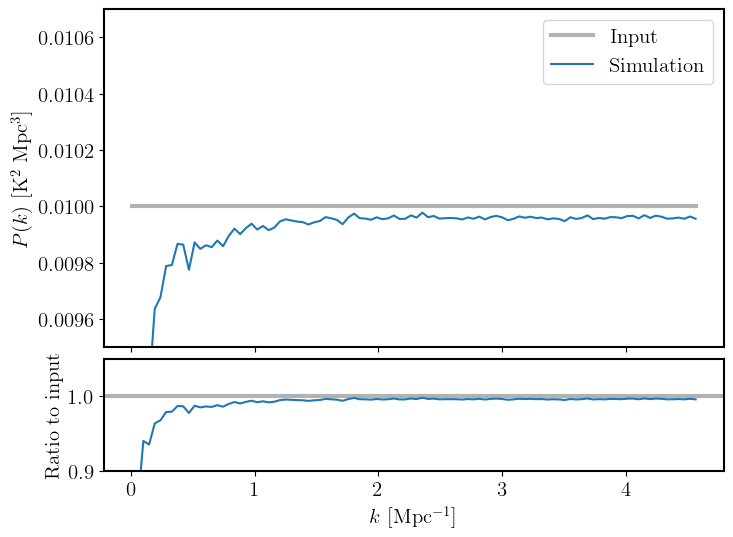

In [49]:
# Compare results
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True,
                         gridspec_kw={'height_ratios':(3, 1), 'hspace':0.05})

# spectra
axes[0].plot(krange, flat_ps(krange, amp), label = 'Input',
             color='k', lw=3., alpha=.3)
axes[0].plot(krange, pspec_1d_cosmo, label = 'Simulation')

# ratio
axes[1].axhline(1, color='k', lw=3., alpha=.3)
axes[1].plot(krange, pspec_1d_cosmo/flat_ps(krange, amp))

axes[0].set_ylabel(rf"$P(k)$ [{pspec_cosmo.data_unit}$^2$ Mpc$^3$]")
axes[1].set_ylabel(r"Ratio to input")
axes[-1].set_xlabel(r"$k$ [Mpc$^{-1}$]")
axes[0].legend(loc = 'best')
axes[-1].set_ylim(0.9, 1.05)
axes[0].set_ylim(amp*0.95, amp*1.07)

(0.95, 1.02)

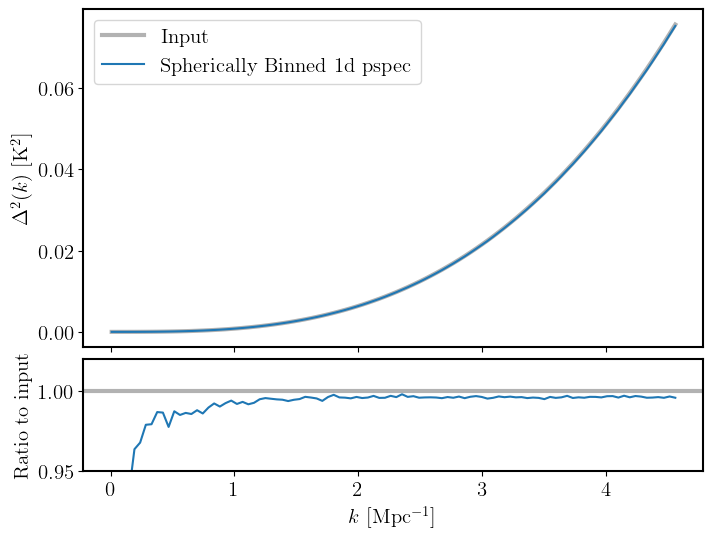

In [51]:
# Dimension-less power spectrum
dimless_pspec = krange**3 * pspec_1d_cosmo / 4.0 / np.pi  # [mk^2]

# Compare results
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True,
                         gridspec_kw={'height_ratios':(3, 1), 'hspace':0.05})

# spectra
axes[0].plot(krange, krange**3 * flat_ps(krange, amp) / 4.0 / np.pi, label = 'Input',
             color='k', lw=3., alpha=.3)
axes[0].plot(krange, dimless_pspec, label = 'Spherically Binned 1d pspec')

# ratio
axes[1].axhline(1, color='k', lw=3., alpha=.3)
axes[1].plot(krange, dimless_pspec/(krange**3 * flat_ps(krange, amp) / 4.0 / np.pi))

axes[0].set_ylabel(fr"$\Delta^2(k)$ [{pspec_cosmo.data_unit}$^2$]")
axes[1].set_ylabel(r"Ratio to input")
axes[-1].set_xlabel(r"$k$ [Mpc$^{-1}$]")
axes[0].legend(loc = 'best')
axes[-1].set_ylim(0.95, 1.02)
# axes[0].set_ylim(amp*0.95, amp*1.07)

#### Cylindrical power spectrum

In [43]:
# cylindrical PS
_, _, pspec_2d_cosmo = pspec_cosmo.compute_2D_pspec(
    ps_data=ps_box_cosmo,
    k_perp_bin=kperp_bins,
    k_par_bin=kpara_bins
)

Text(0.5, 0, 'k$_\\perp$ [Mpc$^{-1}]$')

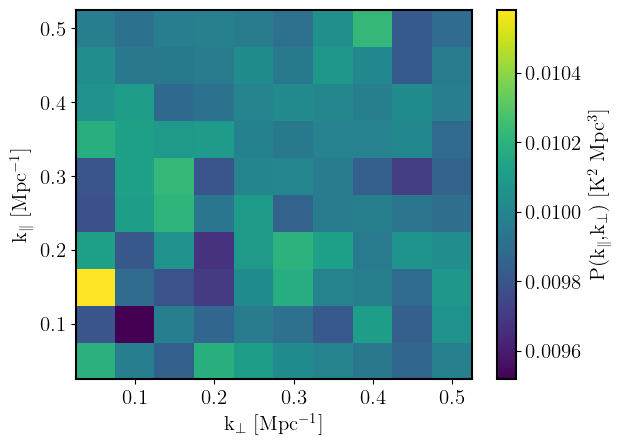

In [46]:
im = plt.pcolor(kperp_bins,
                kpara_bins,
                pspec_2d_cosmo,
                shading='auto')
plt.colorbar(label = f'P(k$_\parallel$,k$_\perp$) [{pspec_cosmo.data_unit}$^2$ Mpc$^3$]')
plt.ylabel('k$_\parallel$ [Mpc$^{-1}]$')
plt.xlabel('k$_\perp$ [Mpc$^{-1}]$')

## Tapering

In [33]:
# power spectrum of cosmo signal only
tapered_pspec = power_spectrum(
    data=cosmo_box,
    theta_x=fov,
    theta_y=fov,
    freqs=spw_window,
    rest_freq=nu0,
    space_taper='bh',
    freq_taper='bh',
    cosmo=cos,
    convert_data_to=None,
    beam_area=omega_B,
    PSF=None,
    verbose=False,
)
# Get FT fields
tapered_ps_box = tapered_pspec.FFT_crossxx(deconvolve=False)

Taking FT of data...


#### Spherical power spectrum

In [34]:
# spherical PS
kweights, tapered_pspec_1d = pspec_cosmo.compute_1D_pspec(
    ps_data=ps_box_cosmo,
    kbins=krange
)

Binning data...


(0.0095, 0.010700000000000001)

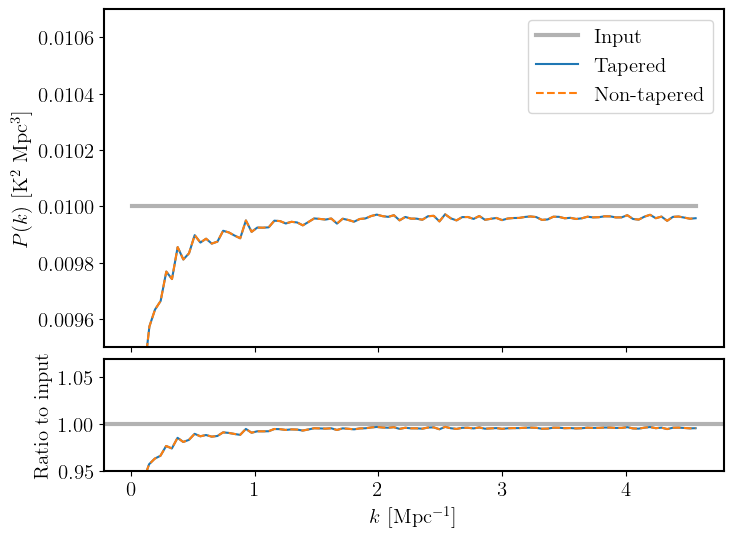

In [35]:
# Compare results
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True,
                         gridspec_kw={'height_ratios':(3, 1), 'hspace':0.05})

# spectra
axes[0].plot(krange, flat_ps(krange, amp), label = 'Input',
             color='k', lw=3., alpha=.3)
axes[0].plot(pspec_1d[0], tapered_pspec_1d[1], label = 'Tapered')
axes[0].plot(pspec_1d[0], pspec_1d[1], label = 'Non-tapered', ls='--')

# ratio
axes[1].axhline(1, color='k', lw=3., alpha=.3)
axes[1].plot(krange, tapered_pspec_1d[1]/flat_ps(krange, amp))
axes[1].plot(krange, pspec_1d[1]/flat_ps(krange, amp), ls='--')

axes[0].set_ylabel(fr"$P(k)$ [{pspec_3d.data_unit}$^2$ Mpc$^3$]")
axes[1].set_ylabel(r"Ratio to input")
axes[-1].set_xlabel(r"$k$ [Mpc$^{-1}$]")
axes[0].legend(loc = 'best')
axes[-1].set_ylim(0.95, 1.07)
axes[0].set_ylim(amp*0.95, amp*1.07)

#### Cylindrical power spectrum

In [36]:
#compute 2D pspec 
k_par, k_perp, tapered_pspec_2d = tapered_pspec.compute_2D_pspec(ps_data=tapered_ps_data)

Binning data...


Text(0.5, 0, 'k$_\\perp$ [Mpc$^{-1}]$')

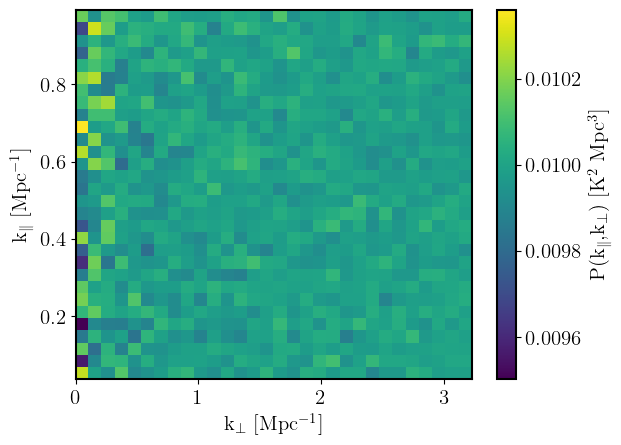

In [37]:
im = plt.pcolor(k_perp,
                k_par,
                tapered_pspec_2d,
                shading='auto')
plt.colorbar(label = f'P(k$_\parallel$,k$_\perp$) [{pspec_3d.data_unit}$^2$ Mpc$^3$]')
plt.ylabel('k$_\parallel$ [Mpc$^{-1}]$')
plt.xlabel('k$_\perp$ [Mpc$^{-1}]$')

## Test conversions

In [54]:
cosmo_box_Jy.value.shape

(2048, 2048, 151)

In [55]:
# power spectrum of cosmo signal only
Jy_pspec = power_spectrum(
    data=cosmo_box_Jy,
    theta_x=fov,
    theta_y=fov,
    freqs=spw_window,
    rest_freq=nu0,
    space_taper=None,
    freq_taper=None,
    cosmo=cos,
    convert_data_to=units.K,
    beam_area=omega_B,
    PSF=None,
    verbose=False,
)
# Get FT fields
Jy_ps_box = Jy_pspec.FFT_crossxx(deconvolve=False)

In [56]:
# spherical PS
kweights, Jy_pspec_1d = Jy_pspec.compute_1D_pspec(
    ps_data=Jy_ps_box,
    kbins=krange
)

(0.95, 1.07)

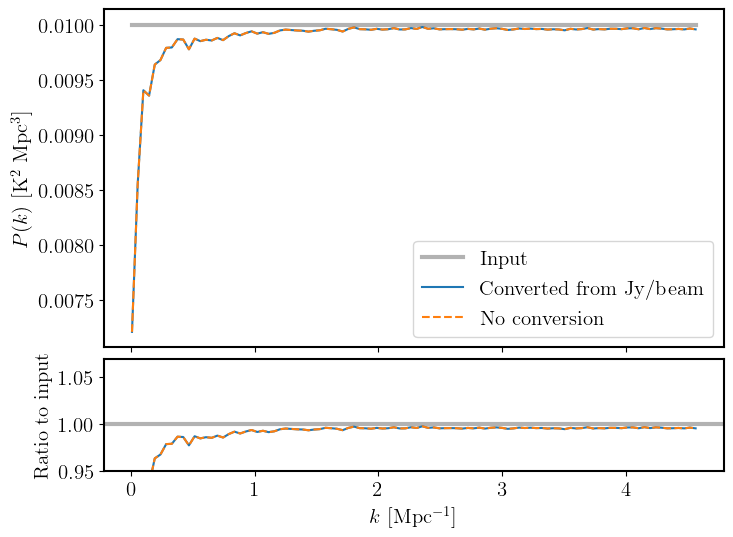

In [57]:
# Compare results
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True,
                         gridspec_kw={'height_ratios':(3, 1), 'hspace':0.05})

# spectra
axes[0].plot(krange, flat_ps(krange, amp), label = 'Input',
             color='k', lw=3., alpha=.3)
axes[0].plot(krange, Jy_pspec_1d, label = 'Converted from Jy/beam')
axes[0].plot(krange, pspec_1d_cosmo, label = 'No conversion', ls='--')

# ratio
axes[1].axhline(1, color='k', lw=3., alpha=.3)
axes[1].plot(krange, Jy_pspec_1d/flat_ps(krange, amp))
axes[1].plot(krange, pspec_1d_cosmo/flat_ps(krange, amp), ls='--')

axes[0].set_ylabel(fr"$P(k)$ [{pspec_cosmo.data_unit}$^2$ Mpc$^3$]")
axes[1].set_ylabel(r"Ratio to input")
axes[-1].set_xlabel(r"$k$ [Mpc$^{-1}$]")
axes[0].legend(loc = 'best')
axes[-1].set_ylim(0.95, 1.07)
# axes[0].set_ylim(amp*0.95, amp*1.07)